### Team Members:
*   Atul Gupta
*   Shubham Kulkarni
*   Nancy Radadia
*   Siddharth Prabhakaran


### Project     : Credit Score Classification

In [1]:
# Importing libraries

import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
import xgboost as xgb
import warnings
warnings.simplefilter("ignore")

In [2]:
# Importing the dataset

file = "train.csv"

X = pd.read_csv(file)

Most of the columns in the dataset are 'object' type. That means, it has different kinds of values from string to integers. For us, it means the data requires a lot of preprocessing and cleaning.

In [3]:
X.dtypes

ID                           object
Customer_ID                  object
Month                        object
Name                         object
Age                          object
SSN                          object
Occupation                   object
Annual_Income                object
Monthly_Inhand_Salary       float64
Num_Bank_Accounts             int64
Num_Credit_Card               int64
Interest_Rate                 int64
Num_of_Loan                  object
Type_of_Loan                 object
Delay_from_due_date           int64
Num_of_Delayed_Payment       object
Changed_Credit_Limit         object
Num_Credit_Inquiries        float64
Credit_Mix                   object
Outstanding_Debt             object
Credit_Utilization_Ratio    float64
Credit_History_Age           object
Payment_of_Min_Amount        object
Total_EMI_per_month         float64
Amount_invested_monthly      object
Payment_Behaviour            object
Monthly_Balance              object
Credit_Score                

In [4]:
# Printing the first row of the dataset to get an idea of the scope of values.

X.iloc[0]

ID                                                                     0x1602
Customer_ID                                                         CUS_0xd40
Month                                                                 January
Name                                                            Aaron Maashoh
Age                                                                        23
SSN                                                               821-00-0265
Occupation                                                          Scientist
Annual_Income                                                        19114.12
Monthly_Inhand_Salary                                             1824.843333
Num_Bank_Accounts                                                           3
Num_Credit_Card                                                             4
Interest_Rate                                                               3
Num_of_Loan                                                     

# Preprocessing and EDA

We have identified the following issues with the data:

1. Includes columns that are not useful. We have identified those columns to be:
    ID, Customer_ID, Month, Name, SSN, Occupation, Num_Bank_Accounts, Num_Credit_Card
2. Numerical columns contain certain non-numerical values like '54_' making the entire column non-numerical.
3. Not Applicable or Not Available values are represented by garbage values like '!@9#%8' in Payment_Behaviour column, 'NM' (Not Mentioned) in Payment_of_Min_Amount column, '_' in CreditMix column etc.
4. Certain numerical values way out of the expected range for example, age being 5000 or number of bank accounts being negative or interest rate being 3000.
5. 'Type_of_Loan' column has 9 unique comma-separated values that generate more than a thousand unique combinations in the dataset.
6. Time period in Credit_History_Age column is expressed as a string.
7. The data set is imbalanced.

These issues are addressed as follows:

1. Removed the columns that are not useful.
2. Converted the entire dataset to string and removed all underscores. Then converted each column to its original datatype.
3. Identified these garbage values and replaced them with np.nan and dropped them later.
4. Defined boundary values for such columns. If any value falls outside of these boundaries, they are replacd with None and then later dropped.
5. Created a unique One Hot Encoder that separates the unique values in 'Type_of_Loan' column into separate columns and uses binary classification to include/exclude these values for every row.
6. Converted the time period into months using regular expressions.
7. Oversampled the dataset to balance it.

## Preprocessing

Defining boundary values and respective functions that address various issues with the dataset.

In [5]:
min_age = 18
max_age = 100
max_num_credit_cards = 10
max_interest_rate = 50
max_num_loans = 20
max_num_credit_inquiries = 50
max_number_of_delayed_payments = 50
min_monthly_balance = -10000
max_monthly_balance = 10000

# Function to remove underscores from a string value
def remove_underscore(value):
    if isinstance(value, str):
        return value.replace('_', '')
    return value

# Function to check if a value falls between min_age and max_age
def check_valid_age(value):
    if value >= min_age and value <= max_age:
        return value
    return None

# Function to check if max number of credit cards fall between expected boundaries.
def check_num_credit_cards(value):
    if value <= max_num_credit_cards:
        return value
    return None

# Function to check interest rate
def check_interest_rate(value):
    if value <= max_interest_rate:
        return value
    return None

# Function to check maximum number of loans
def check_max_num_loan(value):
    if value >= 0 and value <= max_num_loans:
        return value
    return None

# Function to check number of delayed payments
def check_num_delayed_payments(value):
    if isinstance(value, int) and value >= 0 and value <= max_number_of_delayed_payments:
        return value
    return None

# Function to check number of credit inquiries
def check_num_credit_inquiries(value):
    if value <= max_num_credit_inquiries:
        return value
    return None

# Function to check outstanding debt
def check_outstanding_debt(value):
    if value >= 0:
        return value
    return None

# Function to check credit history age
def check_credit_history_age(value):
    match = re.match(r'(\d+) Years and (\d+) Months', value)

    if match:
        years = int(match.group(1))
        months = int(match.group(2))
        total_months = years * 12 + months
        return total_months
    return None

def check_monthly_balance(value):
    if value >= min_monthly_balance and value <= max_monthly_balance:
        return value
    return None


# Function to perform preprocessing steps on a given dataset
def preprocessing(data):

    # Dropping the duplicate rows in the dataset
    data.drop_duplicates(inplace=True)

    integer_columns = ['Age','Num_Bank_Accounts','Num_Credit_Card','Interest_Rate','Num_of_Loan','Delay_from_due_date',
                      'Num_of_Delayed_Payment','Num_Credit_Inquiries']
    float_columns = ['Annual_Income','Monthly_Inhand_Salary','Changed_Credit_Limit','Outstanding_Debt','Credit_Utilization_Ratio',
                    'Total_EMI_per_month','Amount_invested_monthly','Monthly_Balance']

    data['Num_Credit_Inquiries'] = data['Num_Credit_Inquiries'].fillna(0)

    # Converting the entire dataset to strings and then removing underscores by mapping
    data = data.astype(str)
    data = data.applymap(remove_underscore)

    # Re-converting the columns to their respective dtypes after underscores are removed
    for column in integer_columns:
        data[column] = pd.to_numeric(data[column], errors='coerce').astype('Int64')

    for column in float_columns:
        data[column] = pd.to_numeric(data[column], errors='coerce').astype('float64')

    # Applying the defined map functions to clean individual rows.
    data['Age'] = data['Age'].apply(check_valid_age).astype('Int64')
    data['Interest_Rate'] = data['Interest_Rate'].apply(check_interest_rate).astype('Int64')
    data['Num_of_Loan'] = data['Num_of_Loan'].apply(check_max_num_loan).astype('Int64')
    data['Num_of_Delayed_Payment'] = data['Num_of_Delayed_Payment'].apply(check_num_delayed_payments).astype('Int64')
    data['Num_Credit_Inquiries'] = data['Num_Credit_Inquiries'].apply(check_num_credit_inquiries).astype('Int64') #FIX the boolean value issue
    data['Outstanding_Debt'] = data['Outstanding_Debt'].apply(check_outstanding_debt).astype('float64')
    data['Monthly_Balance'] = data['Monthly_Balance'].apply(check_monthly_balance).astype('float64')
    data['Credit_History_Age'] = data['Credit_History_Age'].apply(check_credit_history_age).astype('Int64')
    return data

X = preprocessing(X)

In [6]:
# Dropping irrelevant features

removable_features = ['ID','Customer_ID','Month','Name','SSN','Occupation','Num_Bank_Accounts','Num_Credit_Card']
X = X.drop(removable_features,axis=1)

In [7]:
# Replacing garbage values in categorical columns with np.nan so they can be removed

X["Payment_Behaviour"].replace('!@9#%8',np.nan,inplace=True)
X["Payment_of_Min_Amount"].replace('NM',np.nan,inplace=True)
X["Credit_Mix"].replace('',np.nan,inplace=True)

X.dropna(inplace=True)


## Custom One Hot Encoding for Type_of_Loan column (Feature Engineering)

The dataset has a column that contains a comma separated list of the different types of loans a customer has taken. This is a categorical column. However, the order of these loans creates thousands of permutations. When we closely look at the data, we have 9 different types of loans:

AutoLoan
Credit-BuilderLoan
PersonalLoan
HomeEquityLoan
NotSpecified
MortgageLoan
StudentLoan
DebtConsolidationLoan
PaydayLoan

Therefore, we can create a binary categorical column for each of these loans and populate these columns for each customer. This process is called One Hot Encoding. However, in our case we need to write a custom function that analyzes our list. The process is performed below.

In [8]:
# Dividing the Type_of_Loan column into separate binary categories (specialized one hot encoding)

def custom_one_hot_encoding(X):

    # Finding the unique values in the Type_of_Loan column
    loan_unique = X["Type_of_Loan"].unique()
    type_of_loan = []

    # Cleaning the found values so that 'Auto Loan' and ' and Auto Loan' aren't considered two categories
    for item in loan_unique:
        item_list = item.split(',')
        for loan in item_list:
            loan = loan.replace(' ','')
            loan = loan.replace('and','')
            if loan not in type_of_loan:
                type_of_loan.append(loan)

    # Removing the nan category
    type_of_loan.remove('nan')

    # Creating new columns in the dataset for each unique loan category
    X[type_of_loan] = 0

    # Iterating the dataset by row and updating the binary values in newly created rows
    for index, row in X.iterrows():
        item = row["Type_of_Loan"]
        item_list = item.split(',')
        try:
            item_list.remove('nan')
        except ValueError:
            pass
        for loan in item_list:
            loan = loan.replace(' ','')
            loan = loan.replace('and','')
            X.at[index,loan] = 1

    # Dropping the orginal Type_of_Loan column
    X.drop('Type_of_Loan',axis=1,inplace=True)
    return X

X = custom_one_hot_encoding(X)

In [9]:
X.shape

(35839, 28)

# Visualizing the data and EDA

At this stage, we have cleaned the data and performed preprocessing. We will check dataset balancing later. First, let's visualize the trends in the data to better understand the dataset.

## Credit Mix vs Credit Score

By conventional wisdom, a good credit mix generally leads to a good credit score. Credit mix (or credit diversity) is higher when the customer has invested in various different types of portfolios which then reduces the chance of credit failure.

For more information on credit mix, visit: https://www.capitalone.com/learn-grow/money-management/what-is-credit-mix/

Here we see the same trend visualized by our data.

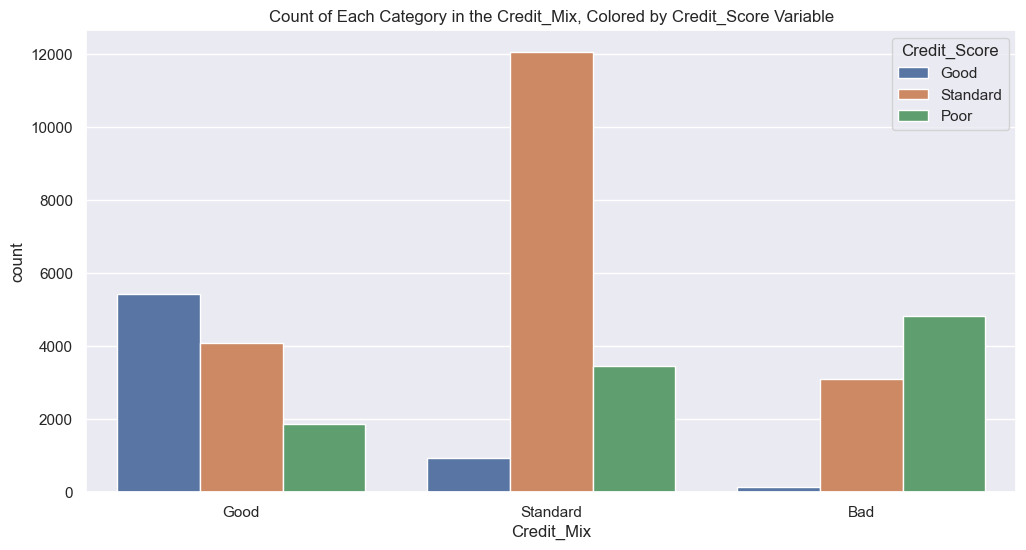

In [10]:
sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))
sns.countplot(x='Credit_Mix', hue='Credit_Score', data=X)

plt.title('Count of Each Category in the Credit_Mix, Colored by Credit_Score Variable')
plt.show()

## Credit inquiries vs Credit Score

Multiple hard inquiries reduce your credit score. However, it is not the only factor that determines credit score of an individual. Here we see a plot of credit inquiries with credit scores to see that trend visualized.

For more information on credit inquiries, visit: https://www.bankrate.com/personal-finance/credit/how-credit-inquiries-affect-credit-score/#multiple

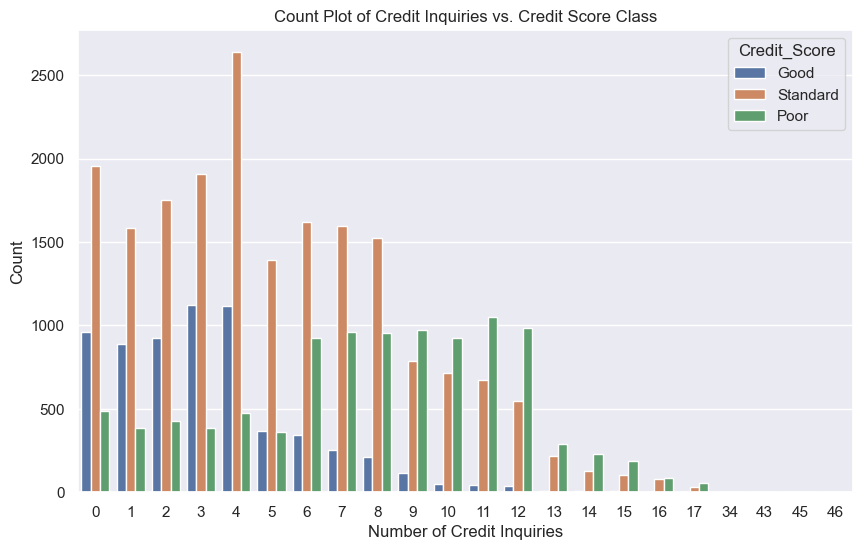

In [11]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Num_Credit_Inquiries', hue='Credit_Score', data=X)

plt.title('Count Plot of Credit Inquiries vs. Credit Score Class')
plt.xlabel('Number of Credit Inquiries')
plt.ylabel('Count')
plt.show()

## Delayed payments vs Credit Score

A payment made after the due data is considered a delayed payment. A few delayed payments are generally not considered a 'score-killer'. However, multiple delayed payments are not good for an individual's credit scores. Here we see the same trend visualized by our data.

For more information, visit:https://www.bankrate.com/personal-finance/credit/payment-history-credit-score/

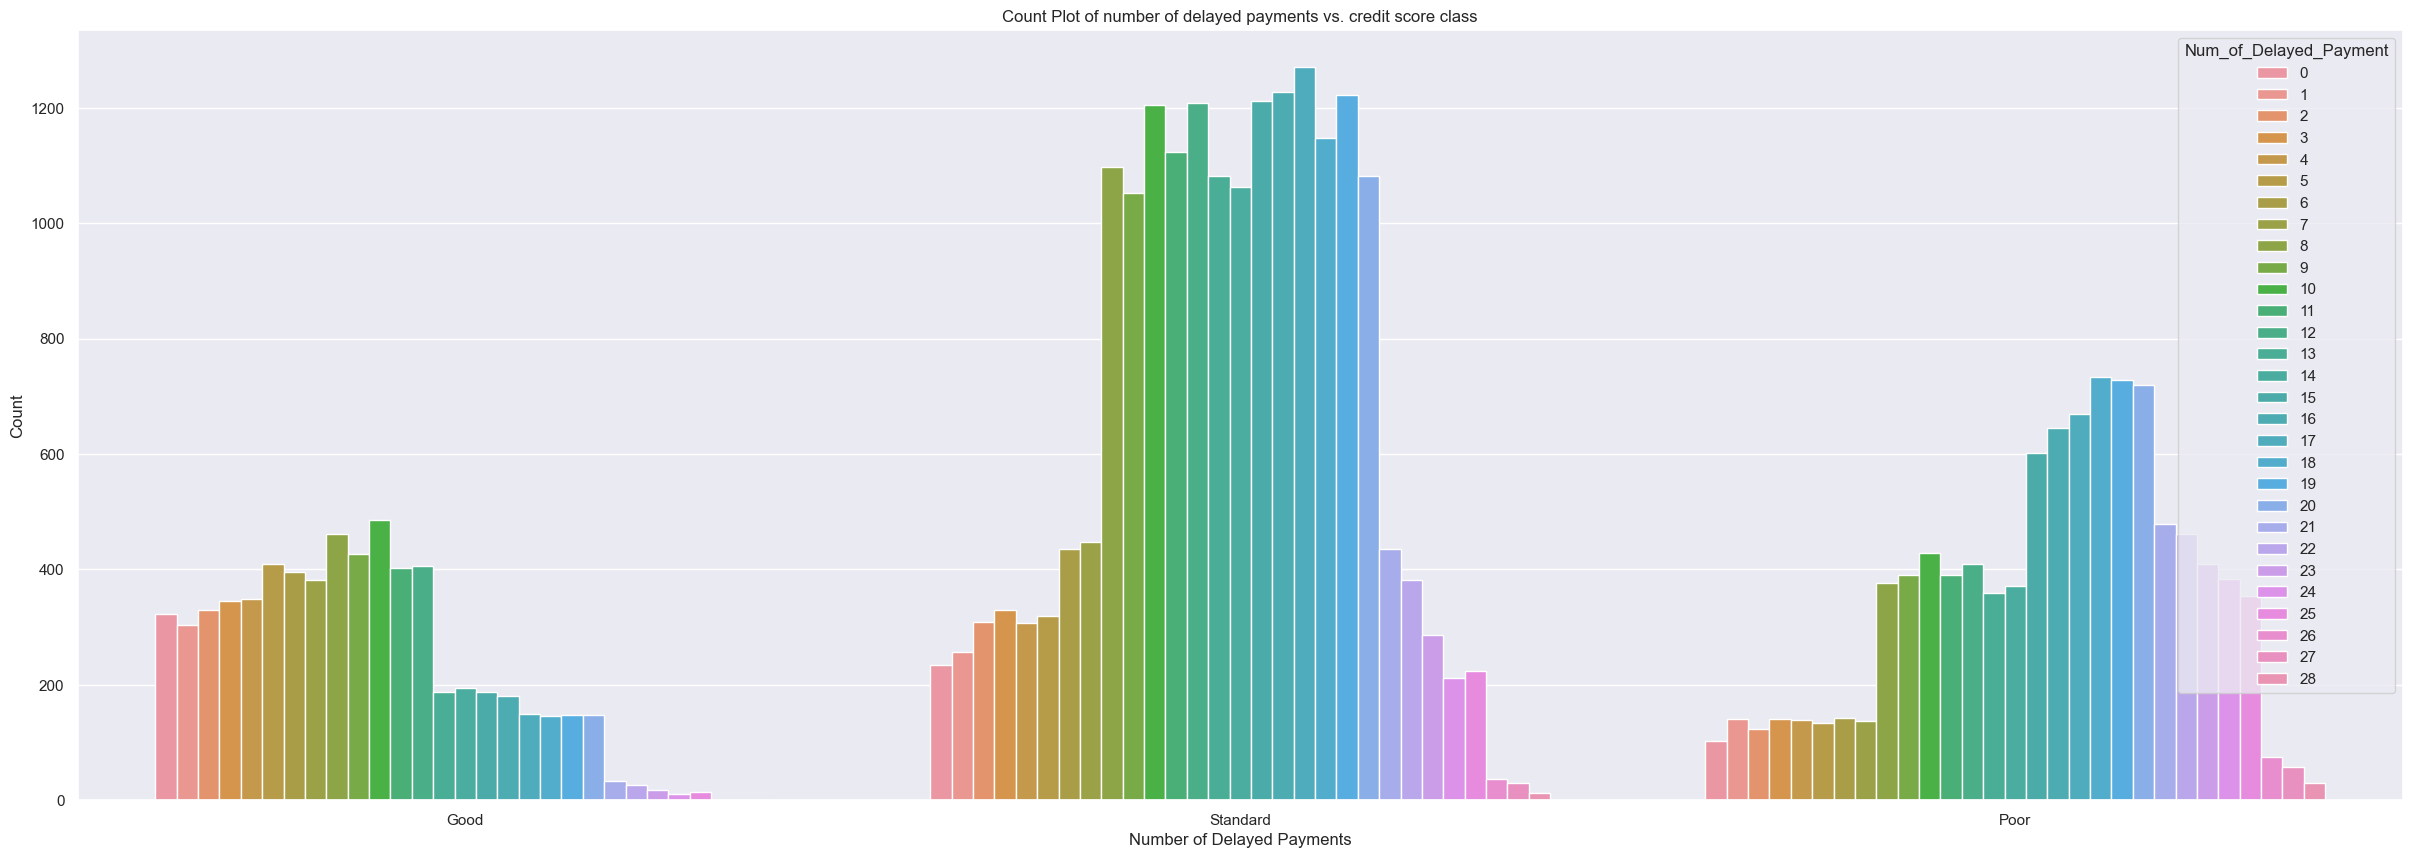

In [12]:
plt.figure(figsize=(30, 10))
sns.countplot(hue='Num_of_Delayed_Payment', x='Credit_Score', data=X)

plt.title('Count Plot of number of delayed payments vs. credit score class')
plt.xlabel('Number of Delayed Payments')
plt.ylabel('Count')
plt.show()

## Annual Income vs Credit Score

Although income doesn't directly affect credit score, it is a relevant factor because it speaks about the current financial condition of the customer. In this plot, we see the distribution of annual income and credit class showing that good/bad/standard credit classes are possible at all levels of income.

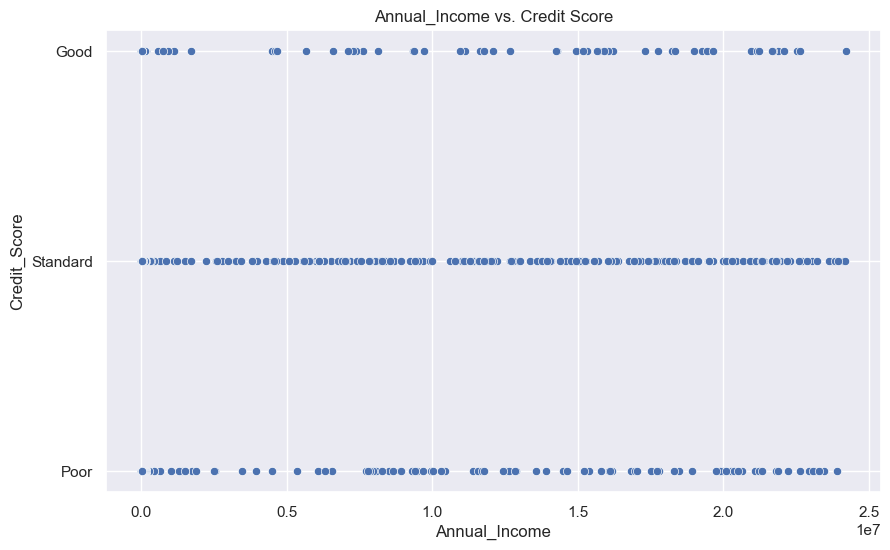

In [13]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Annual_Income', y='Credit_Score', data=X)

plt.title('Annual_Income vs. Credit Score')
plt.show()

# Normalizing the data

Normalizing is the process of translating the data into a range of [0,1] (or any other range). Many machine learning models benefit from normalizing particularly during eucledian distance calculations. Normalization ensures that no feature is given too much weight simply because of the range of its values.

In our dataset, we are using the following steps to normalize the dataset:

1. Categorical colums are either encoded with Label Encoding or One Hot Encoding. Label Encoding is used when there is a relationship between different categories. For example, a category of 'good' ranks higher than a category of 'bad'. For our dataset, the columns Payment_of_Min_Amount and Credit_Mix are label encoded. A column like Payment_Behaviour is One Hot Encoded. That is, its categories are split first and then binary classification is used.
2. The data columns are normalized using MinMaxScaler, which subtracts the minimum of every column from every data point and then divides the result by the difference of the maximum and minimum values. We are using MinMaxScalar instead of StandardScalar to preserve the shape of the distribution and reduce impact of outliers.

In [14]:
def normalize_data(data):
    data['Changed_Credit_Limit'] = data['Changed_Credit_Limit'].round(2)
    label_cols = ['Payment_of_Min_Amount','Credit_Mix']
    encoder_col = 'Payment_Behaviour'
    data_cols = ['Age','Interest_Rate','Num_of_Loan','Changed_Credit_Limit','Delay_from_due_date','Num_of_Delayed_Payment',
                 'Num_Credit_Inquiries','Annual_Income','Monthly_Inhand_Salary','Outstanding_Debt',
                 'Credit_Utilization_Ratio','Credit_History_Age','Total_EMI_per_month','Amount_invested_monthly',
                 'Monthly_Balance']

    for col in label_cols:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])

    encoder = OneHotEncoder(sparse=False)
    data[encoder_col] = encoder.fit_transform(data[encoder_col].values.reshape(-1,1))

    scaler = MinMaxScaler()
    try:
      for column in data_cols:
        data[column] = scaler.fit_transform(data[column].values.reshape(-1,1))
    except:
      pass

    return data

X = normalize_data(X)

le = LabelEncoder()
X["Credit_Score"] = le.fit_transform(X["Credit_Score"])
print(le.classes_)
X.head()

['Good' 'Poor' 'Standard']


,Age,Annual_Income,Monthly_Inhand_Salary,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,...,Credit_Score,AutoLoan,Credit-BuilderLoan,PersonalLoan,HomeEquityLoan,NotSpecified,MortgageLoan,DebtConsolidationLoan,PaydayLoan,StudentLoan
6,0.064935,0.000501,0.102087,0.060606,0.444444,0.111111,0.285714,0.414463,0.086957,1,...,0,1,1,1,1,0,0,0,0,0
8,0.129870,0.001151,0.183501,0.151515,0.111111,0.111111,0.142857,0.277557,0.043478,1,...,2,0,1,0,0,0,0,0,0,0
9,0.129870,0.001151,0.183501,0.151515,0.111111,0.166667,0.035714,0.324362,0.043478,1,...,0,0,1,0,0,0,0,0,0,0
12,0.129870,0.001151,0.183501,0.151515,0.111111,0.111111,0.035714,0.300960,0.043478,1,...,0,0,1,0,0,0,0,0,0,0
13,0.129870,0.001151,0.183501,0.151515,0.111111,0.111111,0.000000,0.277557,0.043478,1,...,0,0,1,0,0,0,0,0,0,0


# Correlation

Correlation is the statistical summary of the relationship between the two variables. A correlation matrix shows the correlation values of each column with every other column. This is useful because it lets us identify which features are most important for our dataset and which features are least important. Using that information, we can remove some of the least correlated features making our dataset more concise and relevant to the task at hand.

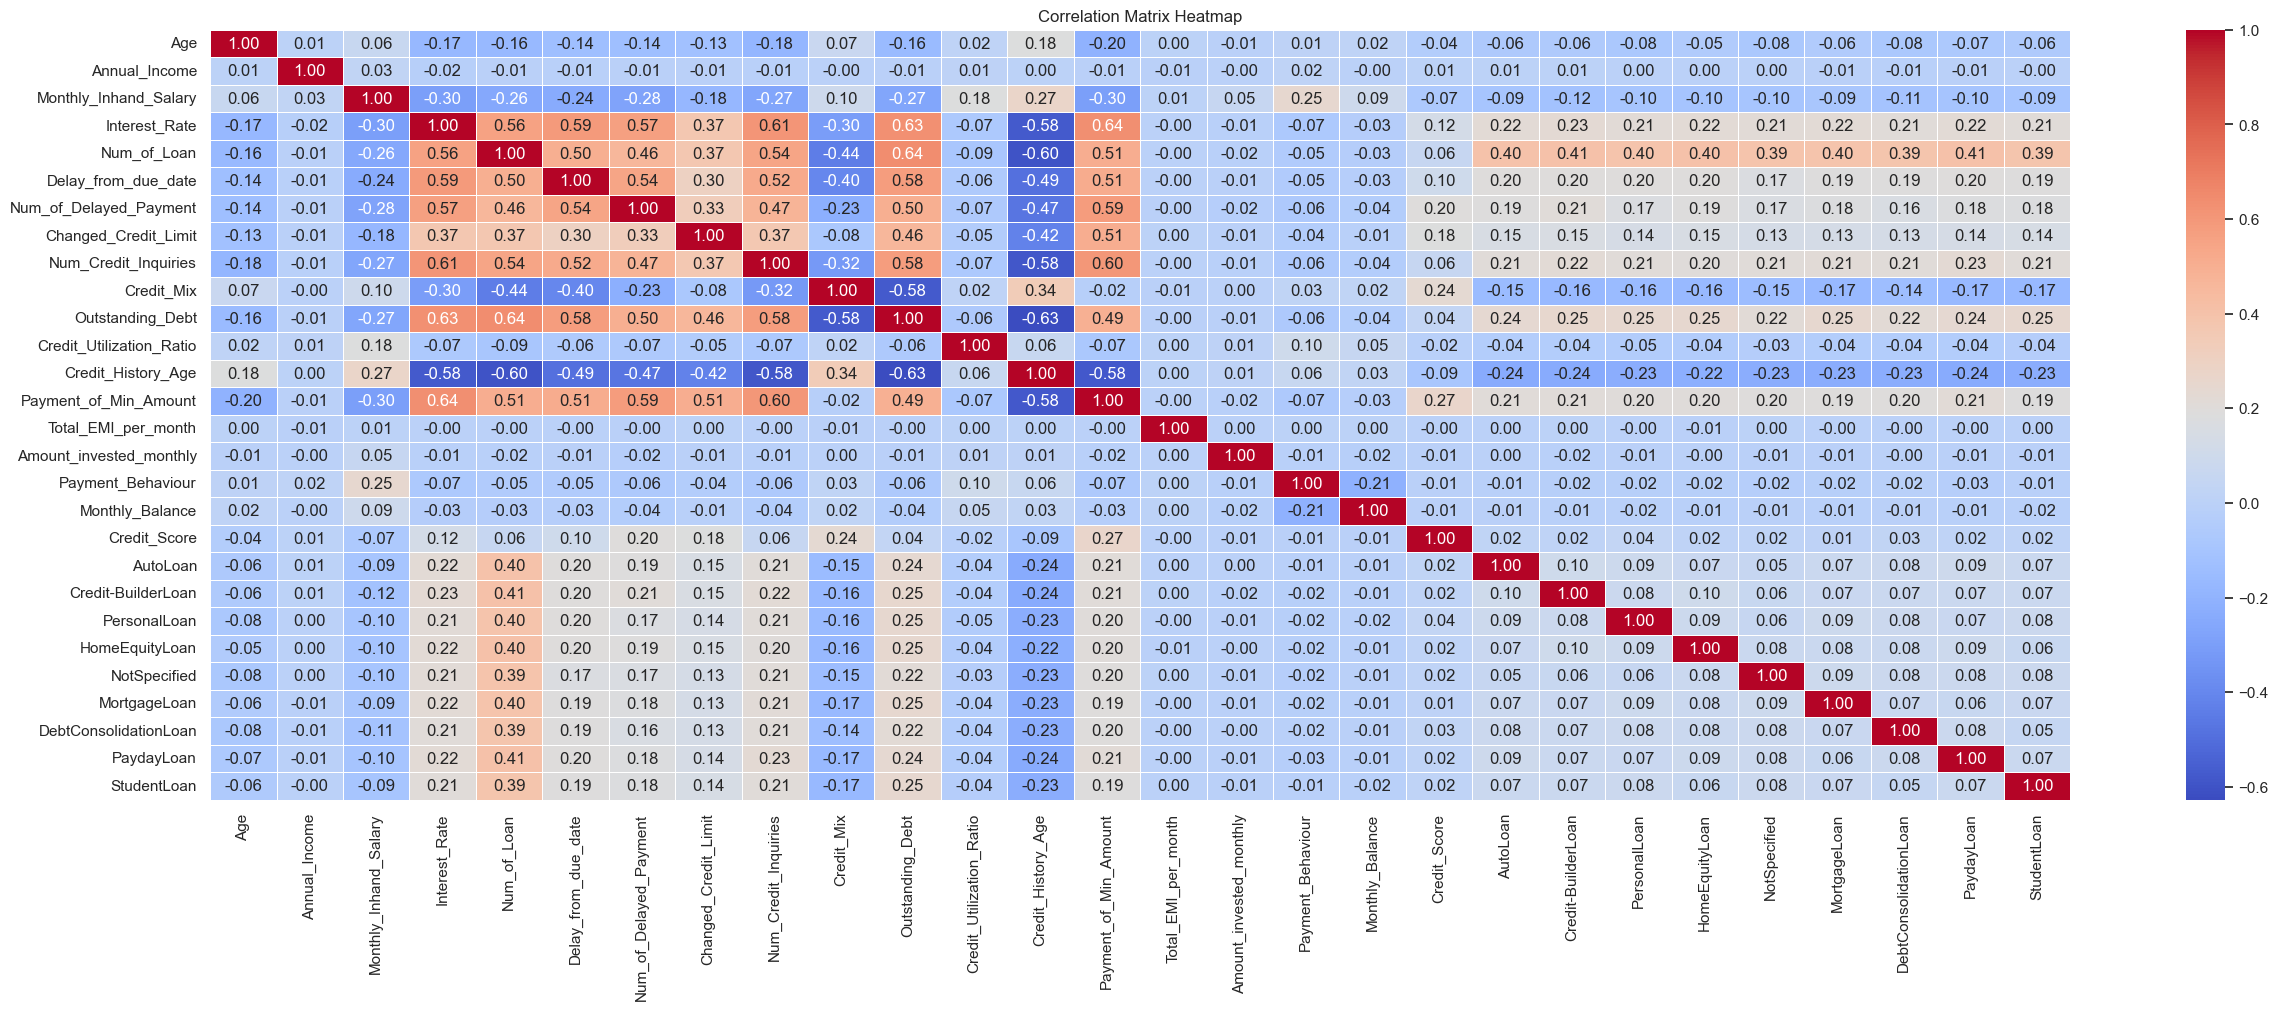

In [15]:
# Correlation matrix
numerical_columns = X.select_dtypes(include=['float64', 'int64','int32'])
corr_matrix = numerical_columns.corr()

plt.figure(figsize=(30, 10))

# Correlation heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

plt.title('Correlation Matrix Heatmap')

plt.show()

Finding the 5 most correlated and 5 least correlated features in the dataset with our target column.

In [16]:
# Sort the features based on their correlation with the target variable
sorted_features = corr_matrix['Credit_Score'].abs().sort_values(ascending=False)


# 5 most and least correlated features with the absolute values of their correlation
print("5 Most Correlated Features:")
print(sorted_features.head(6)[1:])

print("\n5 Least Correlated Features:")
print(sorted_features.tail(5))

5 Most Correlated Features:
Payment_of_Min_Amount     0.267831
Credit_Mix                0.236712
Num_of_Delayed_Payment    0.195891
Changed_Credit_Limit      0.184486
Interest_Rate             0.123187
Name: Credit_Score, dtype: float64

5 Least Correlated Features:
Monthly_Balance            0.009257
Payment_Behaviour          0.008171
Amount_invested_monthly    0.006151
Annual_Income              0.005914
Total_EMI_per_month        0.002120
Name: Credit_Score, dtype: float64


Dropping the three least correlated features.

In [17]:
X.drop(['Num_of_Loan','Annual_Income','Total_EMI_per_month'],inplace=True,axis=1)

In [18]:
X.iloc[0]

Age                         0.064935
Monthly_Inhand_Salary       0.102087
Interest_Rate               0.060606
Delay_from_due_date         0.111111
Num_of_Delayed_Payment      0.285714
Changed_Credit_Limit        0.414463
Num_Credit_Inquiries        0.086957
Credit_Mix                  1.000000
Outstanding_Debt            0.162020
Credit_Utilization_Ratio    0.056882
Credit_History_Age          0.669154
Payment_of_Min_Amount       0.000000
Amount_invested_monthly     0.017834
Payment_Behaviour           0.000000
Monthly_Balance             0.152655
Credit_Score                0.000000
AutoLoan                    1.000000
Credit-BuilderLoan          1.000000
PersonalLoan                1.000000
HomeEquityLoan              1.000000
NotSpecified                0.000000
MortgageLoan                0.000000
DebtConsolidationLoan       0.000000
PaydayLoan                  0.000000
StudentLoan                 0.000000
Name: 6, dtype: float64

In [19]:
X.head()

,Age,Monthly_Inhand_Salary,Interest_Rate,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,...,Credit_Score,AutoLoan,Credit-BuilderLoan,PersonalLoan,HomeEquityLoan,NotSpecified,MortgageLoan,DebtConsolidationLoan,PaydayLoan,StudentLoan
6,0.064935,0.102087,0.060606,0.111111,0.285714,0.414463,0.086957,1,0.162020,0.056882,...,0,1,1,1,1,0,0,0,0,0
8,0.129870,0.183501,0.151515,0.111111,0.142857,0.277557,0.043478,1,0.121012,0.123040,...,2,0,1,0,0,0,0,0,0,0
9,0.129870,0.183501,0.151515,0.166667,0.035714,0.324362,0.043478,1,0.121012,0.606812,...,0,0,1,0,0,0,0,0,0,0
12,0.129870,0.183501,0.151515,0.111111,0.035714,0.300960,0.043478,1,0.121012,0.484109,...,0,0,1,0,0,0,0,0,0,0
13,0.129870,0.183501,0.151515,0.111111,0.000000,0.277557,0.043478,1,0.121012,0.429268,...,0,0,1,0,0,0,0,0,0,0


In [20]:
# Splitting the training dataset into test and train
feature_data = X.drop(['Credit_Score'],axis=1)
target = X['Credit_Score']

X_train, X_test, y_train, y_test = train_test_split(feature_data, target, test_size=0.2)

# Oversampling

A dataset is imbalanced if it has a significant skew in class distribution ie entries of some classes are significantly more in number than those of the other classes. This creates a bias which affects many machine learning algorithms, sometimes leading to the minority class being ignored completely.

Our dataset is imbalanced. The category of class '2' (ie. Good) is significantly more populated. To avoid this bias, we will now perform oversampling. A random oversampling is the process of duplicating examples from the minority class and/or delete examples from the majority class to create a dataset that is balanced by category.

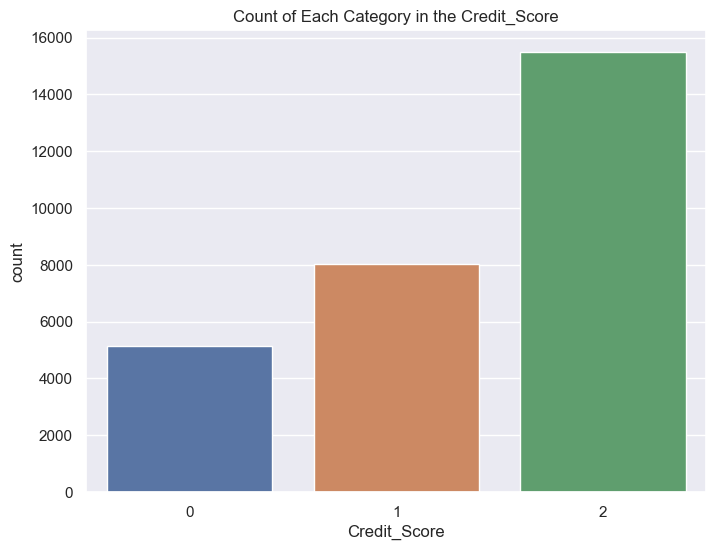

In [21]:
# Checking dataset balancing before oversampling

sns.set(style="darkgrid")
plt.figure(figsize=(8, 6))
sns.countplot(x=pd.Series(y_train))

plt.title('Count of Each Category in the Credit_Score')
plt.show()

As the graph shows, the dataset is clearly skewed in the favor of class 2.

In [22]:
# Oversampling
sample = SMOTE(sampling_strategy='all', random_state=42)
X_train, y_train = sample.fit_resample(X_train, y_train)
X_test, y_test = sample.fit_resample(X_test, y_test)

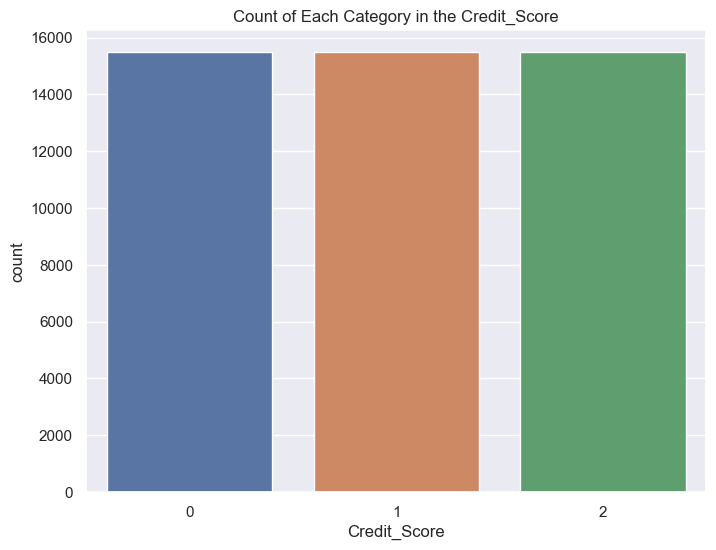

In [23]:
# Balanced dataset
sns.set(style="darkgrid")
plt.figure(figsize=(8, 6))
sns.countplot(x=pd.Series(y_train))

plt.title('Count of Each Category in the Credit_Score')
plt.show()

Dataset is now balanced. Each category has more or less the same representation.

# Classification Modelling

## Logistic Regression


Logisitic Model is a statistical model that models the probability of an event by making the log-odds be a linear combination of independent variables. Logistic Regression is the process of estimating the parameters of a logistic model. We are not using Linear Regression because the relationship between the categories is not linearly separable. We could add a penalty (l1 or l2) in our Logistic Regression model. Here, l1 penalty corresponds to Lasso Regression (ie add the sum of absolute values of the coeffecients to the cost function) and l2 corresponds to Ridge Regression (ie add the sum of squares of the coeffecients to the cost function). However, in our case we have found it unnecessary to add any penalty to our model.

In [24]:
# Logistic Regression
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

## K-Nearest Neighbors

K-Nearest Neighbors or KNN is an instance based learning model that makes predictions based on the similarity of the instances. The similarity is determined based on the distance of the test sample to that of all the training samples. The training samples that have the least distance (ie nearest neighbors) are then selected. The result is then determined based on a simple vote. Generally, the number of nearest neighbors is kept odd to avoid any ties in the vote. Here we are choosing the number as 3.


In [25]:
# K-Nearest Neighbors (KNN)
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)

## Gaussian Naive Bayes

Gaussian naive bayes is a probabilistic classification model that assumes that the features are normally distributed (hence the name 'naive'). Despite the name, the model usually performs well on real-world data. It is simple and computationally efficient. However, it is also more sensitive to outliers because outliers break the assumption that the data is normally distributed. In our case since we have removed the outliers during EDA, the Gaussian Naive Bayes model performs decently.

In [26]:
# Gaussian Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

## Decision Tree

Decision trees are a machine learning model that model decisions based on a tree like structure where each internal node represents a decision on an attribute, each branch represents the outcome of that decision, and the leaf nodes represent the decision on the target variable. Decision trees can handle both numerical and categorical data, making them useful for data that have both. In our case, we have 12 categorical columns (both binary and non-binary) and even more numerical columns. Decision trees,however, can be sensitive to noisy data which we have taken care to remove during preprocessing. Here the random_state variable is a seed variable that makes the results reproducible.

In [27]:
# Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

## Random Forest

Random forest is an ensemble learning technique that creates multiple decision trees and makes classification decisions based on the vote by these decision trees. Here, the parameters n_estimators control the number of decision trees that the Random Forest model will create. In our case, we have used n_estimators to be 100 (which is the default). Random forests are less sensitive to noise in the data.

In [28]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

## XGBoost

XGBoost (or Extreme Gradient Boosting) is a powerful machine learning model that belongs to the family of gradient boosting methods. Gradient boosting is an ensemble machine learning technique that combines the results from several weak learners (typically decision trees) to create a strong predictive model. The basic idea is to train new models to correct the errors of the combined ensemble. XGBoost is high performing, scalable and versatile in handling various kinds of data. Here the objective variable lets us decide the type of objective function that we want to use. We have used 'multi:softmax' implying we are using non-binary or multiclass classification using the softmax cost function. And we have also specified the number of classes in our dataset as 3.

In [29]:
# XGBoost
xgb_model = XGBClassifier(objective='multi:softmax',num_class = 3, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

## AdaBoost

Adaboost is an ensemble boosting algorithm that improves the performance of weak learners (typically decision trees) to create a stronger predictive model. Adaboost assigns weights to data points and focuses on misclassified data points in successive iterations. The final decision is made by a weighted vote of each weak learner. Adaboost is sensitive to outliers (since the model can focus too much on misclassified outliers) and computationally intensive, but is also resistive to overfitting. Here we are using decision trees as the base learners. These decision trees have max_depth of 1, indicating they are decision stumps. That is, these trees make decisions based on a single feature of the input data.

In [30]:
# AdaBoost
adaboost_model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=50, random_state=42)
adaboost_model.fit(X_train, y_train)
y_pred_adaboost = adaboost_model.predict(X_test)

## Bagging Classifier

Bagging (Bootstrap Aggregating) classifier is an ensemble learning technique that improves the stability and performance of weak learners (typically decision trees). Bagging is the process of creating multiple bootstrap samples (random samples with replacement) from the original training dataset. Each sample is then used to train a different weak learner. The predictions for new data is based on voting by these independently trained learners (aggregation). In our case, we are using 50 Decision Trees as base learners.

In [31]:
# Bagging Classifier
bagging_model = BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42), n_estimators=50, random_state=42)
bagging_model.fit(X_train, y_train)
y_pred_bagging = bagging_model.predict(X_test)

## Support Vector Classification

Support Vector Classification is an implementation of Support Vector Machines for classification tasks that is capable of capturing complex decision boundaries. SVM finds the hyperplane that best separates the data into different classes. The hyperplane is chosen to maximize the margin between the classes (for better generalization to unseen data), and the data points that are crucial in defining this margin are called support vectors. A hyperplane is a decision boundary. For two dimensional data it is a line. For three dimensions it is a plane. For more than 3 dimensions it is a hyperplane. Different kernels are used to handle non-linear decision boundaries. Here, C is the regularization parameter that balances between a low training error and a large margin. In our case, we tried using poly, rbf and sigmoid kernels as well. However, the linear kernel gives us the best results.

In [32]:
# Support Vector Classification (SVC)
svc_model = SVC(kernel='linear', random_state=42)
svc_model.fit(X_train, y_train)
y_pred_svc = svc_model.predict(X_test)

# Performance Evaluation

Logistic Regression Model:
Accuracy: 0.69

Confusion Matrix:
 [[3136   70  553]
 [ 727 2407  625]
 [ 782  765 2212]]

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.83      0.75      3759
           1       0.74      0.64      0.69      3759
           2       0.65      0.59      0.62      3759

    accuracy                           0.69     11277
   macro avg       0.69      0.69      0.68     11277
weighted avg       0.69      0.69      0.68     11277

K-Nearest Neighbors (KNN) Model:
Accuracy: 0.70

Confusion Matrix:
 [[2762  280  717]
 [ 373 2739  647]
 [ 692  680 2387]]

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.73      0.73      3759
           1       0.74      0.73      0.73      3759
           2       0.64      0.64      0.64      3759

    accuracy                           0.70     11277
   macro avg       0.70      0.70      0.70     11277
wei

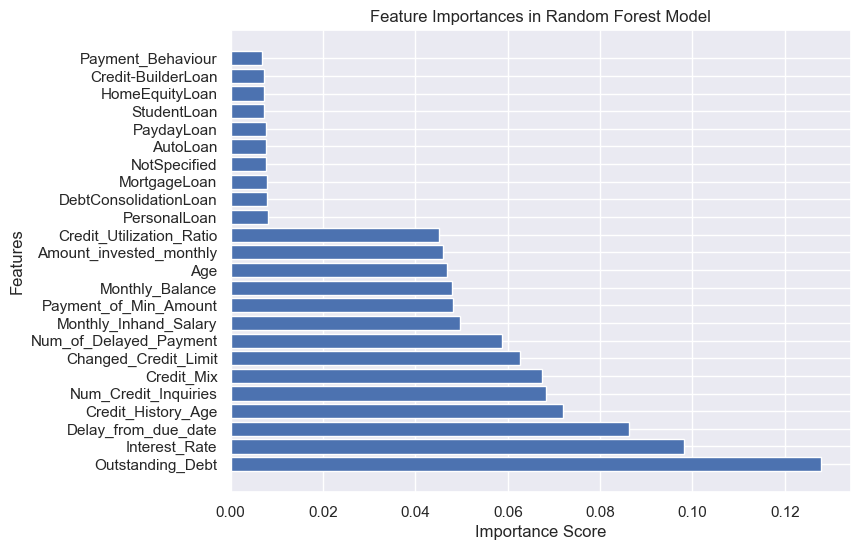

XGBoost Model:
Accuracy: 0.78

Confusion Matrix:
 [[3214  176  369]
 [ 471 2814  474]
 [ 496  492 2771]]

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.86      0.81      3759
           1       0.81      0.75      0.78      3759
           2       0.77      0.74      0.75      3759

    accuracy                           0.78     11277
   macro avg       0.78      0.78      0.78     11277
weighted avg       0.78      0.78      0.78     11277

AdaBoost Classifier Model:
Accuracy: 0.70

Confusion Matrix:
 [[3140   93  526]
 [ 735 2377  647]
 [ 762  661 2336]]

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.84      0.75      3759
           1       0.76      0.63      0.69      3759
           2       0.67      0.62      0.64      3759

    accuracy                           0.70     11277
   macro avg       0.70      0.70      0.69     11277
weighted avg       0.

In [33]:
# Evaluate the models
models = [
    ("Logistic Regression", lr_model, y_pred_lr, y_test),
    ("K-Nearest Neighbors (KNN)", knn_model, y_pred_knn, y_test),
    ("Gaussian Naive Bayes", nb_model, y_pred_nb, y_test),
    ("Decision Tree", dt_model, y_pred_dt, y_test),
    ("Random Forest", rf_model, y_pred_rf, y_test),
    ("XGBoost", xgb_model, y_pred_xgb, y_test),
    ("AdaBoost Classifier", adaboost_model, y_pred_adaboost, y_test),
    ("Bagging Classifier", bagging_model, y_pred_bagging, y_test),
    ("Support Vector Classification (SVC)", svc_model, y_pred_svc, y_test)
]

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for model_name, model, y_pred, y_true in models:
    accuracy = accuracy_score(y_true, y_pred)
    accuracy_scores.append(accuracy)
    conf_matrix = confusion_matrix(y_true, y_pred)
    classification_rep = classification_report(y_true, y_pred)

    precision_scores.append(precision_score(y_true, y_pred,average='macro'))
    recall_scores.append(recall_score(y_true,y_pred,average='macro'))
    f1_scores.append(f1_score(y_true, y_pred,average='macro'))

    print(f"{model_name} Model:")
    print(f'Accuracy: {accuracy:.2f}')
    print('\nConfusion Matrix:\n', conf_matrix)
    print('\nClassification Report:\n', classification_rep)
    print("="*40)
    if model_name == 'Random Forest':
      feature_importances = rf_model.feature_importances_

      # Create a DataFrame with feature names and their importance scores
      feature_importance_df = pd.DataFrame({
          'Feature': X_train.columns,
          'Importance': feature_importances
      })

      # Sort the DataFrame by importance in descending order
      feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

      # Plot the feature importances
      plt.figure(figsize=(8, 6))
      plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
      plt.xlabel('Importance Score')
      plt.ylabel('Features')
      plt.title('Feature Importances in Random Forest Model')
      plt.show()

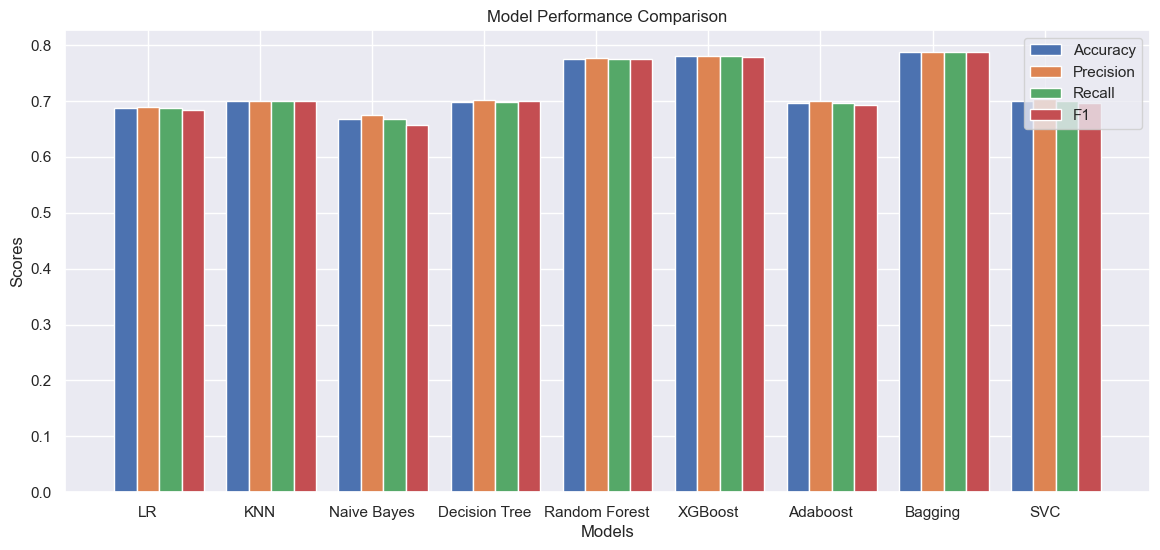

In [34]:
model_names = ['LR', 'KNN', 'Naive Bayes', 'Decision Tree', 'Random Forest', 'XGBoost',
               'Adaboost', 'Bagging', 'SVC']

# Number of models
num_models = len(model_names)


fig, ax = plt.subplots(figsize=(14, 6))

# Bar width
bar_width = 0.2
bar_positions = np.arange(num_models)

# Plot bars for each metric
plt.bar(bar_positions - bar_width, accuracy_scores, width=bar_width, label='Accuracy')
plt.bar(bar_positions, precision_scores, width=bar_width, label='Precision')
plt.bar(bar_positions + bar_width, recall_scores, width=bar_width, label='Recall')
plt.bar(bar_positions + 2 * bar_width, f1_scores, width=bar_width, label='F1')

# Add labels, title, and legend
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Performance Comparison')
plt.xticks(bar_positions, model_names)
plt.legend()

# Show the plot
plt.show()